In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

In [2]:
batch_size = 512
epochs = 20
learning_rate = 1e-3

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(root="../../../datasets", train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root="../../../datasets", train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=False)

In [4]:
class Autoencoder(nn.Module):
    def __init__(self, **kwargs):
        super(Autoencoder, self).__init__()
        
        self.input_shape = kwargs["input_shape"]
        self.hidden_layer_sizes = kwargs["hidden_layer_sizes"]
        self.activation_fn = kwargs["activation_fn"]
        
        # encoder
        encoder_layers = []
        encoder_layers.append(nn.Linear(in_features=self.input_shape, out_features=self.hidden_layer_sizes[0]))
        encoder_layers.append(self.activation_fn(inplace=True))
        for i in range(1, len(self.hidden_layer_sizes)):
            encoder_layers.append(nn.Linear(in_features=self.hidden_layer_sizes[i-1], out_features=self.hidden_layer_sizes[i]))
            encoder_layers.append(self.activation_fn(inplace=True))
        self.encoder = nn.Sequential(*encoder_layers)

        # decoder
        decoder_layers = []
        for i in range(len(self.hidden_layer_sizes)-1, 0, -1):
            decoder_layers.append(nn.Linear(in_features=self.hidden_layer_sizes[i], out_features=self.hidden_layer_sizes[i-1]))
            decoder_layers.append(self.activation_fn(inplace=True))
        decoder_layers.append(nn.Linear(in_features=self.hidden_layer_sizes[i-1], out_features=self.input_shape))
        decoder_layers.append(self.activation_fn(inplace=True))
        self.decoder = nn.Sequential(*decoder_layers)
        
    def forward(self, x):
                    
        x = self.encoder(x)
        x = self.decoder(x)
            
        return x
    
    def generate_code(self, x):
        return self.encoder(x)


In [5]:
input_shape = 784
HIDDEN_LAYER_UNITS = [256, 128, 64]
ACTIVATION_FUNCTION = nn.ReLU

In [6]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device: ", device)

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = Autoencoder(input_shape=input_shape,
                    hidden_layer_sizes=HIDDEN_LAYER_UNITS,
                   activation_fn=ACTIVATION_FUNCTION)
model = model.to(device)
print("model: ", model)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print("optimizer: ", optimizer)

# mean-squared error loss
criterion = nn.MSELoss()
print("criterion: ", criterion)

device:  cuda
model:  Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): ReLU(inplace=True)
  )
)
optimizer:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)
criterion:  MSELoss()


In [7]:
for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        
        batch_features = batch_features.view(-1, 784).to(device)  # [512, 1, 28, 28] to [512, 784]
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    
    # display the epoch training loss
    print("epoch : {}/{}, recon loss = {:.8f}".format(epoch + 1, epochs, loss))

epoch : 1/20, recon loss = 0.06538534
epoch : 2/20, recon loss = 0.03317936
epoch : 3/20, recon loss = 0.02609319
epoch : 4/20, recon loss = 0.02258298
epoch : 5/20, recon loss = 0.02014454
epoch : 6/20, recon loss = 0.01842909
epoch : 7/20, recon loss = 0.01717085
epoch : 8/20, recon loss = 0.01613888
epoch : 9/20, recon loss = 0.01539210
epoch : 10/20, recon loss = 0.01467546
epoch : 11/20, recon loss = 0.01409373
epoch : 12/20, recon loss = 0.01367638
epoch : 13/20, recon loss = 0.01326640
epoch : 14/20, recon loss = 0.01291591
epoch : 15/20, recon loss = 0.01264628
epoch : 16/20, recon loss = 0.01241061
epoch : 17/20, recon loss = 0.01216407
epoch : 18/20, recon loss = 0.01193824
epoch : 19/20, recon loss = 0.01176450
epoch : 20/20, recon loss = 0.01156458


In [8]:
with torch.no_grad():
    for batch_features in test_loader:
        batch_features = batch_features[0]
        test_examples = batch_features.view(-1, 784).to(device)
        reconstruction = model(test_examples)
        break

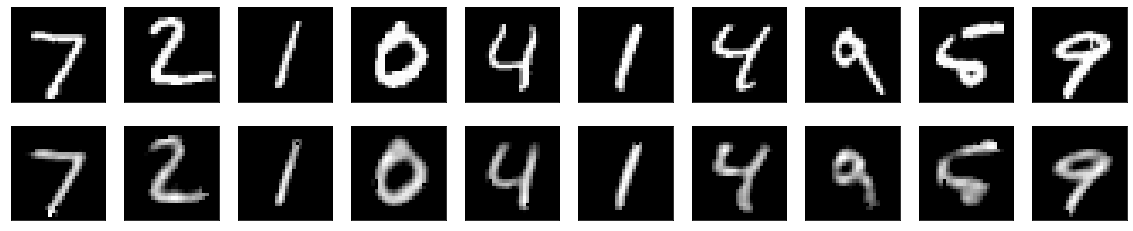

In [9]:
with torch.no_grad():
    number = 10
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples[index].cpu().numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction[index].cpu().numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [10]:
with torch.no_grad():
    code = []
    labels = []
    for batch_features, label in test_loader:
        test_examples = batch_features.view(-1, 784).to(device)
        code.append(model.generate_code(test_examples).cpu().numpy())
        labels.append(label.numpy())
    code = np.array(code).reshape(-1, HIDDEN_LAYER_UNITS[-1])
    labels = np.array(labels)

In [11]:
print("code.shape: ", code.shape)
print("labels.shape: ", labels.shape)

code.shape:  (10000, 64)
labels.shape:  (1000, 10)


In [12]:
g_embedded = PCA(n_components=2).fit_transform(code)

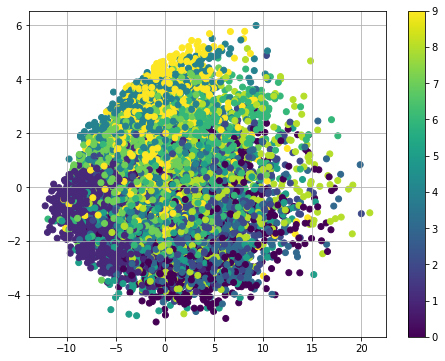

In [13]:
plt.figure(figsize=(8, 6)) 
plt.scatter(g_embedded[:, 0], g_embedded[:, 1], c=labels, cmap='viridis')
plt.colorbar()
plt.grid()